<a href="https://colab.research.google.com/github/Lee-nahyung/AI-image/blob/main/%EC%9D%B4%EB%B9%A8%20%EA%B7%B8%EB%9E%98%ED%94%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import os
import time
import copy
import glob
import cv2
import shutil

import torchvision.models as models

import torch.optim as optim
import torch
import torchvision.datasets as datasets
import torch.optim.lr_scheduler as lr_scheduler


from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()   # 데이터 불러오기

Saving LeopardCatAndCat.zip to LeopardCatAndCat.zip


In [2]:
!unzip LeopardCatAndCat.zip -d LeopardCatAndCat/    #LeopardCatAndCat 폴더 압축풀기

Archive:  LeopardCatAndCat.zip
   creating: LeopardCatAndCat/LeopardCatAndCat/test/
   creating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8100.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8101.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8102.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8103.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8104.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8105.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8106.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8107.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8108.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8109.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8110.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat/8111.jpg  
  inflating: LeopardCatAndCat/LeopardCatAndCat/test/Cat

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #gpu 우선으로 돌릴 것

In [4]:
#train 셋이다. 
data_path = '/content/LeopardCatAndCat/LeopardCatAndCat/train/'
transform = transforms.Compose(
                [
                    transforms.Resize([256, 256]),
                    transforms.RandomResizedCrop(224),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                ])
train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    num_workers=8,
    shuffle=True
)

print(len(train_dataset))

#--train 셋이다

220


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
#test셋이다

test_path = '/content/LeopardCatAndCat/LeopardCatAndCat/test'

transform = transforms.Compose(
                [
                    transforms.Resize(224),
                    transforms.CenterCrop(224),
                    transforms.ToTensor(),
                ])
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

print(len(test_dataset))
#--test셋이다

40


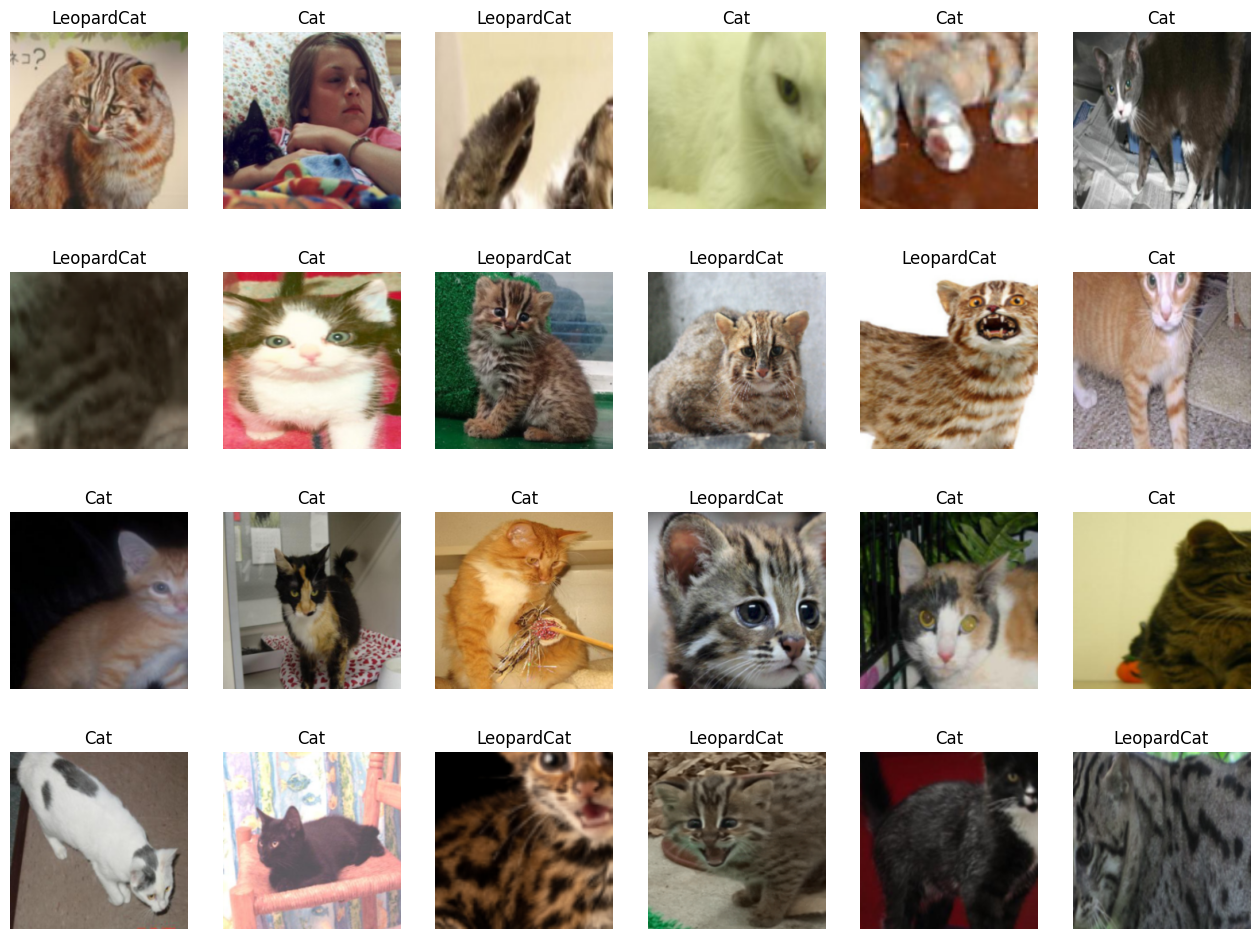

In [6]:
#dataset 보여주기
samples, labels = next(iter(train_loader))
classes = {0:'Cat', 1:'LeopardCat'}
fig = plt.figure(figsize=(16,24))
for i in range(24):
    a = fig.add_subplot(4,6,i+1)
    a.set_title(classes[labels[i].item()])
    a.axis('off')
    a.imshow(np.transpose(samples[i].numpy(), (1,2,0)))
plt.subplots_adjust(bottom=0.2, top=0.6, hspace=0)
#--dataset보여주기

In [15]:
resnet = torchvision.models.resnet18(pretrained=True)

ftr = resnet.fc.in_features
resnet.fc = nn.Linear(ftr, 5)

resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0012) #옵티마이저로 아담 사용

total_step = len(train_loader)
Loss = []
Acc = []
Val_Loss = []
Val_Acc = []
n=20

dataset = train_dataset
train = train_dataset
val = test_dataset

#total_samples = len(dataset)
#train_size = len(train_dataset)
#val_size = len(test_dataset)

#train, val = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=32, shuffle=True)

for epoch in range(n):
  acc = 0
  val_acc = 0
  for i, (images, labels) in enumerate(train_loader):
    resnet.train()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = resnet(images)
    loss = criterion(outputs, labels)
    
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  acc = acc/len(train_loader.dataset) * 100
    
  for i, (images, labels) in enumerate(val_loader):
    resnet.eval()
    images = images.to(device)
    labels = labels.to(device)
    
    # Forward pass
    outputs = resnet(images)
    val_loss = criterion(outputs, labels)
    
    # Checking accuracy
    preds = outputs.data.max(dim=1,keepdim=True)[1]
    val_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
  val_acc = val_acc/len(val_loader.dataset) * 100
    
  print("Epoch {} =>  loss : {loss:.2f};   Accuracy : {acc:.2f}%;   Val_loss : {val_loss:.2f};   Val_Accuracy : {val_acc:.2f}%".format(epoch+1, loss=loss.item(), acc=acc, val_loss=val_loss.item(), val_acc=val_acc))

  Loss.append(loss)
  Acc.append(acc)

  Val_Loss.append(val_loss)
  Val_Acc.append(val_acc)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 =>  loss : 0.70;   Accuracy : 70.91%;   Val_loss : 1.39;   Val_Accuracy : 70.00%
Epoch 2 =>  loss : 0.18;   Accuracy : 85.91%;   Val_loss : 0.94;   Val_Accuracy : 95.00%
Epoch 3 =>  loss : 0.51;   Accuracy : 89.09%;   Val_loss : 1.20;   Val_Accuracy : 87.50%
Epoch 4 =>  loss : 0.37;   Accuracy : 88.64%;   Val_loss : 2.51;   Val_Accuracy : 95.00%
Epoch 5 =>  loss : 0.28;   Accuracy : 90.91%;   Val_loss : 0.01;   Val_Accuracy : 90.00%
Epoch 6 =>  loss : 0.26;   Accuracy : 91.82%;   Val_loss : 0.46;   Val_Accuracy : 70.00%
Epoch 7 =>  loss : 0.04;   Accuracy : 93.18%;   Val_loss : 1.42;   Val_Accuracy : 67.50%
Epoch 8 =>  loss : 0.11;   Accuracy : 93.18%;   Val_loss : 0.97;   Val_Accuracy : 70.00%
Epoch 9 =>  loss : 0.20;   Accuracy : 95.00%;   Val_loss : 0.10;   Val_Accuracy : 97.50%
Epoch 10 =>  loss : 0.05;   Accuracy : 98.18%;   Val_loss : 0.03;   Val_Accuracy : 97.50%
Epoch 11 =>  loss : 0.22;   Accuracy : 95.00%;   Val_loss : 0.23;   Val_Accuracy : 92.50%
Epoch 12 =>  loss :

<ipython-input-16-aecbde2ca97a>:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


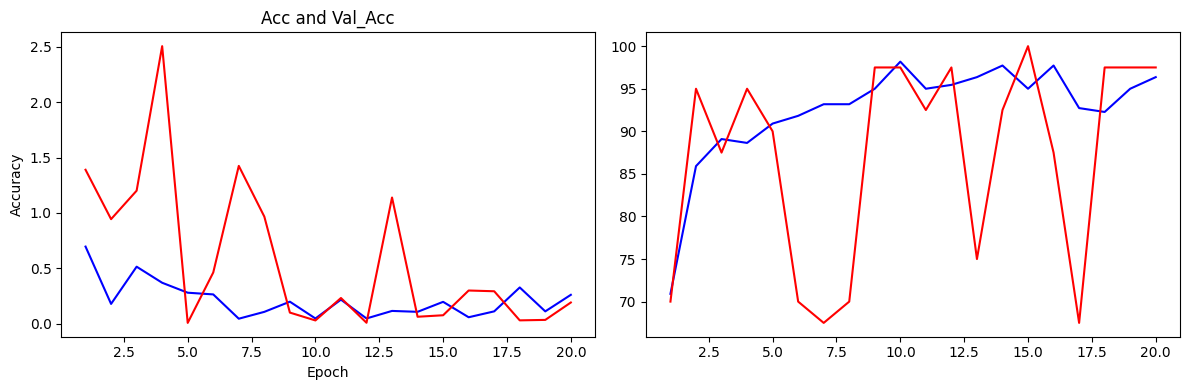

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# plot 1
plt.figure(figsize=(12, 4))
plt.title("Acc_loss and Val_loss")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.subplot(1, 2, 1)
plt.plot(range(1, len(Loss)+1), [loss.detach().numpy() for loss in Loss], color='blue', label='Loss')  # Loss 그래프
plt.plot(range(1, len(Val_Loss)+1), [loss.detach().numpy() for loss in Val_Loss], color='red', label='Val_Loss')  # Val_Loss 그래프

#plot 2
plt.title("Acc and Val_Acc")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.subplot(1, 2, 2)
plt.plot(range(1, len(Acc)+1), [acc.detach().numpy() for acc in Acc], color='blue', label='Accuracy')
plt.plot(range(1, len(Val_Acc)+1), [acc.detach().numpy() for acc in Val_Acc], color='red', label='Val_Acc')

plt.tight_layout()
plt.show()

RuntimeError: ignored

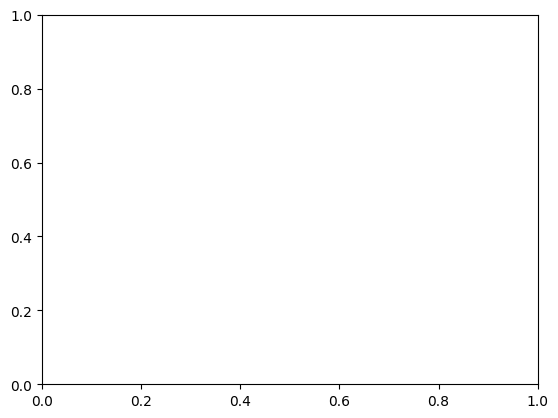

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#show

t1 = np.array
plt.plot(range(n),Loss)
plt.plot(range(n),Val_Loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()

In [ ]:
actual = []
deep_features = []

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        features = resnet18(images)

        deep_features += features.cpu().numpy().tolist()
        actual += labels.cpu().numpy().tolist()

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
cluster = np.array(tsne.fit_transform(np.array(deep_features)))
actual = np.array(actual)

plt.figure(figsize=(5, 5))
name = ['', 'dog']
for i, label in zip(range(2), name):
    idx = np.where(actual == i)
    plt.scatter(cluster[idx, 0], cluster[idx, 1], marker='.', label=label)

plt.legend()
plt.show()